# 用PyTorch实现CIFAR10图片分类器
https://pytorch.apachecn.org/docs/1.2/beginner/blitz/cifar10_tutorial.html

## 一、引入需要的包

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## 二、下载并处理CIFAR10数据集

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0.6%

98.7%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


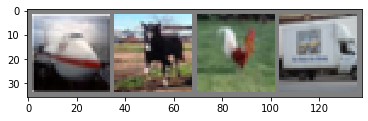

plane horse  bird truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## 三、搭建神经网络

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
print(net) #显示的是init的层，不是forward的

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 四、定义损失函数和优化器

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #用交叉熵损失
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #用随机梯度下降（使用momentum）

## 五、训练网络

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # i代表第i个batch
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.194
[1,  4000] loss: 1.839
[1,  6000] loss: 1.649
[1,  8000] loss: 1.555
[1, 10000] loss: 1.484
[1, 12000] loss: 1.450
[2,  2000] loss: 1.369
[2,  4000] loss: 1.352
[2,  6000] loss: 1.328
[2,  8000] loss: 1.304
[2, 10000] loss: 1.289
[2, 12000] loss: 1.283
Finished Training


## 六、测试网络

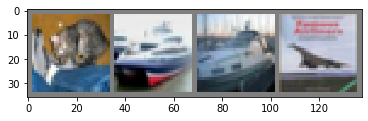

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) # GroundTruth代表测试样本的真是label

In [11]:
# 网络预测的输出
outputs = net(images)
print(outputs)

tensor([[-0.5840, -2.6549,  0.3350,  3.4403, -0.7962,  2.3938,  1.2410, -0.9055,
         -0.5929, -1.6848],
        [ 3.7612,  5.5853, -1.0751, -2.5073, -3.1412, -4.8571, -3.8005, -3.7798,
          6.9275,  4.7495],
        [ 2.6371,  2.6601, -0.0071, -1.4071, -1.4354, -2.9487, -2.6207, -1.8076,
          3.5578,  2.5564],
        [ 3.2139,  1.6672,  0.9548, -1.8110, -1.0834, -3.3752, -1.9374, -2.5716,
          4.5154,  1.1498]], grad_fn=<AddmmBackward>)


In [12]:
# 将网络预测的输出转换成label
_, predicted = torch.max(outputs, 1) #取最大值的下标

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


In [13]:
# 统计网络在整个测试集上的表现
correct = 0
total = 0
with torch.no_grad():
    for data in testloader: # data是一个batch
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


这比随机选取（即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

In [15]:
# 查看各个类别的表现
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 58 %
Accuracy of  bird : 35 %
Accuracy of   cat : 31 %
Accuracy of  deer : 34 %
Accuracy of   dog : 48 %
Accuracy of  frog : 82 %
Accuracy of horse : 58 %
Accuracy of  ship : 65 %
Accuracy of truck : 76 %


# 在GPU上训练
- 与将一个张量传递给GPU一样，可以这样将神经网络转移到GPU上。
- 如果希望使用您所有GPU获得更大的加速，也即多GPU训练，请查看：https://pytorch.apachecn.org/docs/1.2/beginner/blitz/data_parallel_tutorial.html

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


如果有GPU的话，应该会输出cuda:0之类的，然后将网络、输入、输出放到GPU，再进行网络训练。

In [17]:
net.to(device)
inputs, labels = inputs.to(device), labels.to(device)